In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from glob import glob
import pydicom
import tensorflow as tf
import tqdm as tqdm
import tensorflow_io as tfio
import pathlib
import datetime
# tensorboard
%load_ext tensorboard
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [1]:
!pip install -q ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q ../input/for-pydicom/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

# Creating the Dataset tf.Dataset.from_tensor_slices #

In [ ]:
class cl_CreatingDataset:
    def __init__(self, imageHeight, imageWidth, batch_size):
        self.imageHeight = imageHeight
        self.imageWidth = imageWidth
        self.batch_size = batch_size

    
    def creatingPathList(self, trainImagesPath, trainDfPath):
        trainDf = pd.read_csv(trainDfPath)
        trainImagesPathList = []
        labels = []
        # reading the tain CSV
        trainDf = pd.read_csv(trainDfPath)
        for i in tqdm.tqdm(range(len(trainDf))):
            folderName = trainDf["StudyInstanceUID"].iloc[i]
            imageFolderPath = os.path.join(trainImagesPath, folderName)
            for file in glob(os.path.join(imageFolderPath, "*.dcm")):
                # taking the imageName
                trainImagesPathList.append(file)
                # creating the labels
                label = np.array([trainDf["C1"].iloc[i],trainDf["C2"].iloc[i], trainDf["C3"].iloc[i], trainDf["C4"].iloc[i], trainDf["C5"].iloc[i], 
                                 trainDf["C6"].iloc[i], trainDf["C7"].iloc[i], trainDf["patient_overall"].iloc[i]])
                labels.append(label)
        
        return trainImagesPathList, labels
    
    def parse_function(self, filename, label):
        image_bytes = tf.io.read_file(filename)
        image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.float32)
        #image = tf.image.convert_image_dtype(image, tf.float32)
        resized_image = tf.image.resize(image, [self.imageHeight, self.imageWidth])
        compressedImage = tf.squeeze(resized_image, axis = 0)
        finalImage = tf.repeat(compressedImage, repeats=[3], axis = 2)
        return finalImage, label
        
    def train_preprocess(self, image, label):
        return image, label


    def creatingDataset(self, filenames, labels):
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
        dataset = dataset.shuffle(len(filenames))
        dataset = dataset.map(self.parse_function, num_parallel_calls=4)
        dataset = dataset.map(self.train_preprocess, num_parallel_calls=4)
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(1)

        return dataset

# Creating Dataset using Generator Concept (tf.data.Dataset.fromgenerator) #

In [3]:
DATA_DIR = "../input/rsna-2022-cervical-spine-fracture-detection/"
trainCsv = "../input/rsna-2022-cervical-spine-fracture-detection/train.csv"
train_df = pd.read_csv(trainCsv)
print(train_df.head())

            StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3  1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4   1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0


In [4]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path: the path of the required dicom file
    returns:
        data: image pixel arrays
    """
    img=pydicom.dcmread(path)
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    return data

In [5]:
def data_generator():
    for i, study_instance in enumerate(train_df.StudyInstanceUID[:]):
        for dcm in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            train_labels = []
            path = DATA_DIR + f"train_images/{study_instance}/{dcm}"
            img = load_dicom(path)
            
            # resize each image into a shape of (512, 512)
            img = np.resize(img, (512, 512))
            #  normalize image
            img = img / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            
            train_labels.extend([
                train_df.loc[i, "C1"],
                train_df.loc[i, "C2"],
                train_df.loc[i, "C3"],
                train_df.loc[i, "C4"],
                train_df.loc[i, "C5"],
                train_df.loc[i, "C6"],
                train_df.loc[i, "C7"],
                train_df.loc[i, "patient_overall"] # end with patient overall
            ])
            yield img, train_labels

## Splitting the dataset ##

In [6]:
def splitDataset(dataset, trainFactor, img_count): # here it refers to tf.dataset
    train_dataset = dataset.take(int(trainFactor * img_count))
    validation_dataset = dataset.take(int((1 - trainFactor)* img_count))
    
    return train_dataset, validation_dataset
    

In [7]:
def configure_for_performance(data):
    data = data.cache()
    data = data.batch(16)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

## Creating the model ##

In [8]:
def creating_model(opt):
    IMG_SHAPE = (512, 512, 3)
    base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    
    base_model.trainable = False
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(8, activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

trainCsv = "../input/rsna-2022-cervical-spine-fracture-detection/train.csv"
trainImagePath = "../input/rsna-2022-cervical-spine-fracture-detection/train_images"
creDataset = cl_CreatingDataset(224, 224, 4)
trainImagesPathList, labels = creDataset.creatingPathList(trainImagePath, trainCsv)
print("train Image list :", len(trainImagePath), ".....", "train label list : ", len(labels))


In [9]:
# this is required because of length of dataset is not valid for generators
def getImageCount():
    img_count = 0
    for _, study_instance in enumerate(train_df.StudyInstanceUID[:5]):
        for _ in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            img_count += 1
            
    return img_count

## Callbacks ##

In [12]:
def createTensorboardCallback(logdir):
    return tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

    
def saveModelCallback(filePath):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filePath, monitor='val_loss',verbose=1, save_best_only=True, mode='min')
    
    return checkpoint
    

## Displaying the training graphs ##

In [14]:
def display(history):
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# creating the dataset
dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int8))

# printing a sample data for checking
for img, label in dataset.take(1):
    print(img.shape)
    print(label.shape)
    print(label)

# splitting the dataset
trainFactor = 0.8
img_count = getImageCount()
print("[***] Images for training and validation : ", img_count)
train_data, validation_data = splitDataset(dataset, trainFactor, img_count)
#
train_dataset = configure_for_performance(train_data)
validation_dataset = configure_for_performance(validation_data)

# creating and compiling the model
INIT_LR = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
model = creating_model(opt)
#model = alex_net()
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
# training
EPOCHS = 10
BATCH_SIZE = 4
# tensorboard logging dir
foldername = "/kaggle/working/tensorboardRecord"
os.makedirs(foldername, exist_ok=True)
logdir = os.path.join(foldername, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


# modelsave checkpoint
modelDir = "/kaggle/working/modelDir"
os.makedirs(modelDir, exist_ok=True)
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
modelSavePath = os.path.join(modelDir, filepath)

tensorboardCallback = createTensorboardCallback(logdir)
modeSaveCallback = saveModelCallback(modelSavePath)
history = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = validation_dataset, callbacks=[modeSaveCallback])


(512, 512, 3)
(8,)
tf.Tensor([1 1 0 0 0 0 0 1], shape=(8,), dtype=int8)
[***] Images for training and validation :  1734
115277824/115263384 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, 16, 16, 2048)      28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 28,529,919
Trainable params: 16,392
Non-trainable params:

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
87/87 [==============================] - 35s 400ms/step - loss: 0.3414 - binary_accuracy: 0.8624 - val_loss: 0.7626 - val_binary_accuracy: 0.6622

Epoch 00002: val_loss improved from 0.91634 to 0.76257, saving model to /kaggle/working/modelDir/my_best_model.epoch02-loss0.76.hdf5
Epoch 3/10
87/87 [==============================] - 35s 399ms/step - loss: 0.3154 - binary_accuracy: 0.8609 - val_loss: 0.7532 - val_binary_accuracy: 0.6622

Epoch 00003: val_loss improved from 0.76257 to 0.75323, saving model to /kaggle/working/modelDir/my_best_model.epoch03-loss0.75.hdf5
Epoch 4/10
87/87 [==============================] - 35s 400ms/step - loss: 0.3120 - binary_accuracy: 0.8602 - val_loss: 0.7577 - val_binary_accuracy: 0.6622

Epoch 00004: val_loss did not improve from 0.75323
Epoch 5/10
87/87 [==============================] - 35s 399ms/step - loss: 0.3143 - binary_accuracy: 0.8600 - val_loss: 0.7349 - val_binary_accuracy: 0.6622

Epoch 00005: val_loss improved from 0.75323 to 0.73

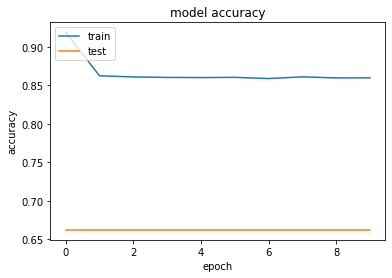

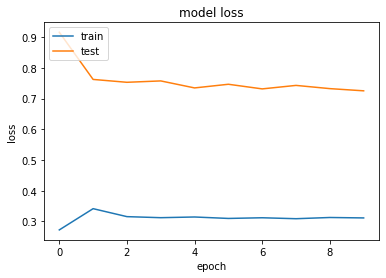

In [16]:
import matplotlib.pyplot as plt
display(history)